# **SHIPPING PORT INSPECTION ANALYSIS**

## **Business Understanding**

Delays in ship arrivals and departures at a port can have significant consequences, leading to bottlenecks, increased operational costs, and customer dissatisfaction. Efficiently managing ship schedules is crucial to maintaining the smooth operation of port activities.

#### *Why Cost Management is Important*
If port authority predict that a ship will be delayed, and this prediction is accurate most of the time, port authority can trust these predictions. They can plan their operations around these predictions, reducing unnecessary changes and adjustments.

`Example.`
If the cost/expenditure for handling one ship is Rp 10.000.000 and there is 80 ships that needs to be handled each day for the port. means that port authority at least needs Rp 800.000.000 each day just to keep the operational going smoothly while the actual ship that will arrive on the port is only 30-40 of them. Means that port authority just loss around Rp 400.000.0000 only for expenditure.

#### *Precision*
Since the delayed ship will be predicted with 1 and on time ship will be predicted with 0. Port authority wants to make sure the data can accurately predict the ship that will arrive on time without considering delay ship. Therefore, the metrics that should be focused is precision.

<br>

## **Set Up**


#### *Import Modules*

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
import shap

from matplotlib.colors import ListedColormap

from collections import Counter
from sklearn.feature_selection import RFE


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer, PolynomialFeatures, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import plot_tree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, f1_score, recall_score, classification_report, RocCurveDisplay, fbeta_score, make_scorer, balanced_accuracy_score
from sklearn.metrics._scorer import _SCORERS

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import category_encoders as ce
from category_encoders import BinaryEncoder

from imblearn import pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN

# new module
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from scipy.stats import randint

<br>

#### *Load Data*

In [3]:
df = pd.read_csv('shipping_port.csv')
df

,Product type,Order quantities,Shipping carriers,Shipping costs,Origin,Inspection results,Defect rates,Routes,ETA
0,cosmetics,30,Carrier B,10.229816,Kolkata,Pending,1.907666,Route B,Delay
1,skincare,51,Carrier B,8.978751,Kolkata,Pending,0.380574,Route A,On time
2,cosmetics,88,Carrier C,5.588190,Delhi,Pass,0.541154,Route C,On time
3,skincare,76,Carrier C,8.674211,Kolkata,Pass,1.727314,Route B,On time
4,skincare,38,Carrier B,5.773264,Chennai,Fail,0.045302,Route A,On time
...,...,...,...,...,...,...,...,...,...
395,haircare,26,Carrier B,8.630339,Chennai,Fail,4.165782,Route A,Delay
396,skincare,35,Carrier B,6.074264,Chennai,Fail,0.045302,Route A,On time
397,haircare,32,Carrier C,9.031340,Delhi,Fail,3.805533,Route C,Delay
398,haircare,58,Carrier B,1.194252,Bangalore,Fail,1.983468,Route A,On time


<br>

#### *Needed Functions*

In [4]:
def count_outlier(col):
    if pd.api.types.is_numeric_dtype(df[col]):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        upper_whisker = q3+ 1.5 * iqr
        lower_whisker = q1 - 1.5 * iqr

        if lower_whisker == 0:
            return 0
        else:
            counts = len(df[(df[col] > upper_whisker) | (df[col] < lower_whisker)])
            return counts

In [5]:
def count_rare_values(df):
    rare_threshold = 0.05
    rare_counts = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            rare_values_count = df[df[col].map(df[col].value_counts(normalize=True)) <= rare_threshold].shape[0]
        else:
            value_counts = df[col].value_counts(normalize=True)
            rare_values_count = (value_counts <= rare_threshold).sum()

        rare_counts.append(rare_values_count)

    return rare_counts

<br>

## **Data Understanding**

#### *Initial Review*

In [6]:
pd.DataFrame({
    'Features': df.columns,
    'type': df.dtypes.values,
    'null value %': df.isna().mean().values * 100,
    'outlier': [count_outlier(col) for col in df.columns],
    'rare values < 5%' : count_rare_values(df),
    'nunique': df.nunique().values,
    'unique': [df[col].unique() for col in df.columns]
})

,Features,type,null value %,outlier,rare values < 5%,nunique,unique
0,Product type,object,0.0,NaN,0,3,"[cosmetics, skincare, haircare]"
1,Order quantities,int64,0.0,0.0,400,96,"[30, 51, 88, 76, 38, 11, 77, 62, 82, 60, 69, 4..."
2,Shipping carriers,object,0.0,NaN,0,3,"[Carrier B, Carrier C, Carrier A]"
3,Shipping costs,float64,0.0,0.0,400,306,"[10.22981625, 8.978750756, 5.58818999, 8.67421..."
4,Origin,object,0.0,NaN,0,5,"[Kolkata, Delhi, Chennai, Mumbai, Bangalore]"
5,Inspection results,object,0.0,NaN,0,3,"[Pending, Pass, Fail]"
6,Defect rates,float64,0.0,0.0,400,100,"[1.907665734, 0.380573587, 0.541154098, 1.7273..."
7,Routes,object,0.0,NaN,0,3,"[Route B, Route A, Route C]"
8,ETA,object,0.0,NaN,0,2,"[Delay, On time]"


From the table above it can be seen that the dataset doesnt have any missing values and outliers. However, on the rare values columns many of the data has various kind of unique values such as oon order quantities, shipping costs, Lead time and Defect rates. This data is important for the understanding and characteristics of the predictions, therefore there will no deleted data.

#### *Duplicate Data*

In [7]:
print("The number of duplicated data is :", df.duplicated().sum())

The number of duplicated data is : 0


There is no duplicated data, means that every data on each row is unique

#### *Statistical Summary*

In [8]:
display(df.describe().round())
display(df.describe(include='object'))

,Order quantities,Shipping costs,Defect rates
count,400.0,400.0,400.0
mean,49.0,6.0,2.0
std,26.0,3.0,1.0
min,1.0,1.0,0.0
25%,26.0,4.0,1.0
50%,51.0,6.0,2.0
75%,69.0,8.0,4.0
max,99.0,10.0,5.0


,Product type,Shipping carriers,Origin,Inspection results,Routes,ETA
count,400,400,400,400,400,400
unique,3,3,5,3,3,2
top,skincare,Carrier B,Kolkata,Pending,Route A,On time
freq,165,173,104,162,167,207


#### *Data Type List*

In [9]:
categorical_columns = [col for col in df if pd.api.types.is_object_dtype(df[col])]
numerical_columns = [col for col in df.drop('ETA', axis=1) if pd.api.types.is_numeric_dtype(df[col])]

display(categorical_columns, numerical_columns)

['Product type',
 'Shipping carriers',
 'Origin',
 'Inspection results',
 'Routes',
 'ETA']

['Order quantities', 'Shipping costs', 'Defect rates']

#### *Review*

From the dataset understanding, it can be found that the data is actually clean since there is no missing value, duplicate, redundant and rare values. Therefore without further data cleaning, However we will change the `df['ETA']` as a target.

* **Delay = 1**
* **On time = 0**

<br>

## **Explanatory Data Analysis (EDA)**

#### *Categorical Column Analysis*

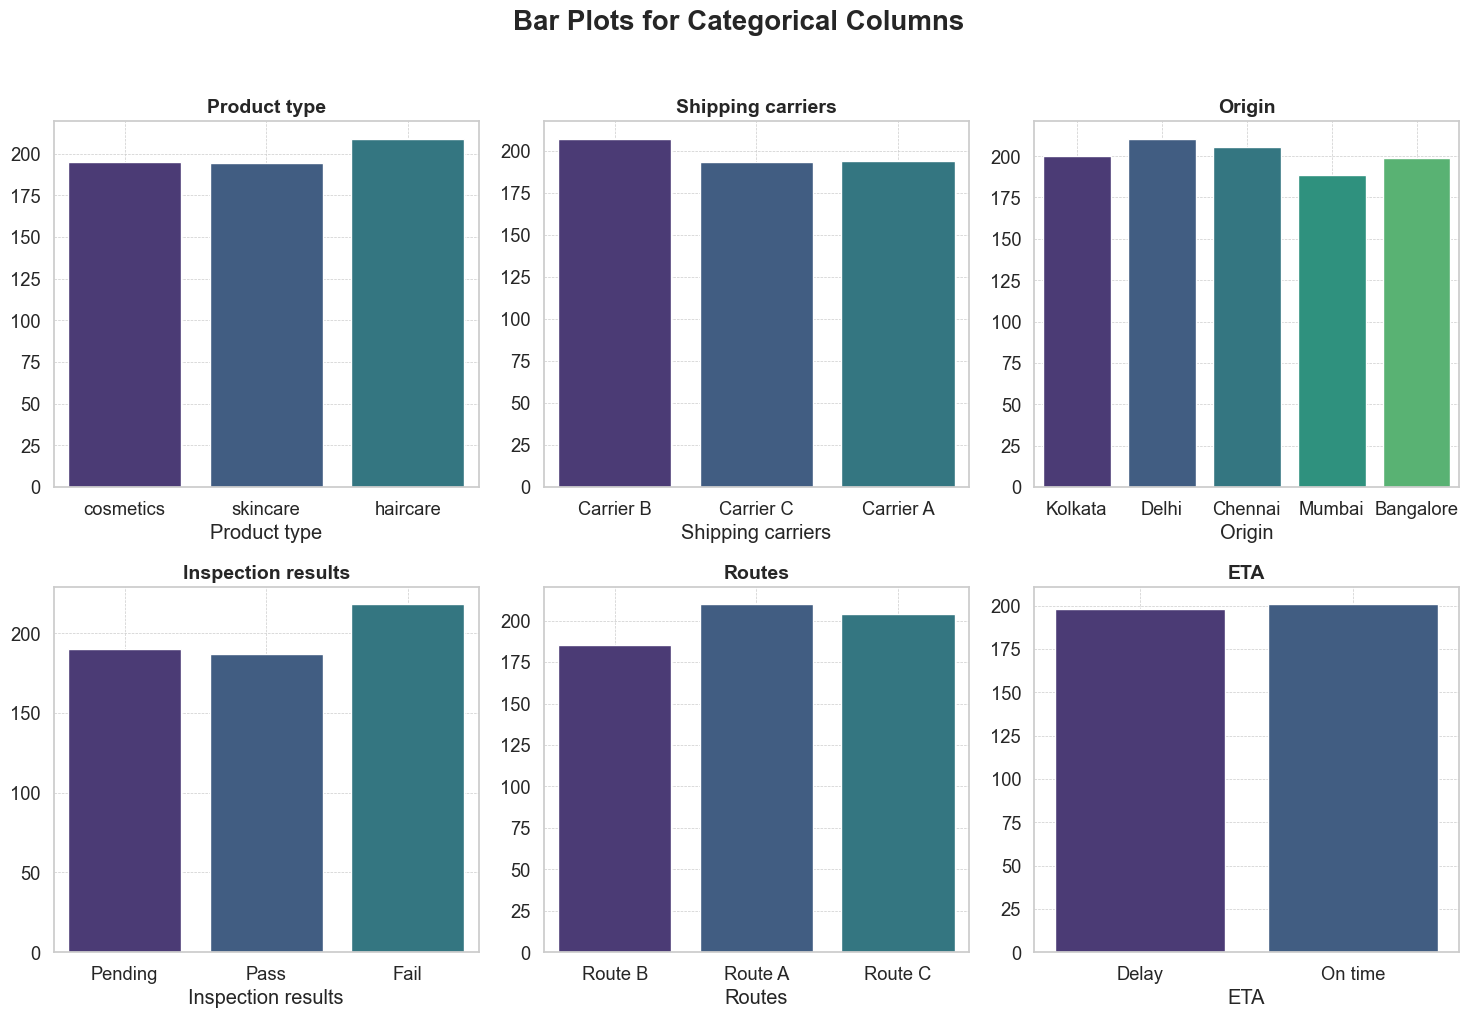

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

ncols = 3
nrows = max(1, -(-len(categorical_columns) // ncols))  # Ceiling division with a minimum of 1 row

sns.set(style='whitegrid', palette='viridis', font_scale=1.2)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.barplot(x=df[col], y=df.index, ax=axes[i], ci=None)
    axes[i].set_title(col, fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Bar Plots for Categorical Columns', fontsize=20, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

From the bar plots above, those represent the proportions of each categorical data. It can be found that there are not many categorical value in each categorical columns. Moreover, there might not be a significance difference from one data to another.

#### *Numerical Column Analysis*

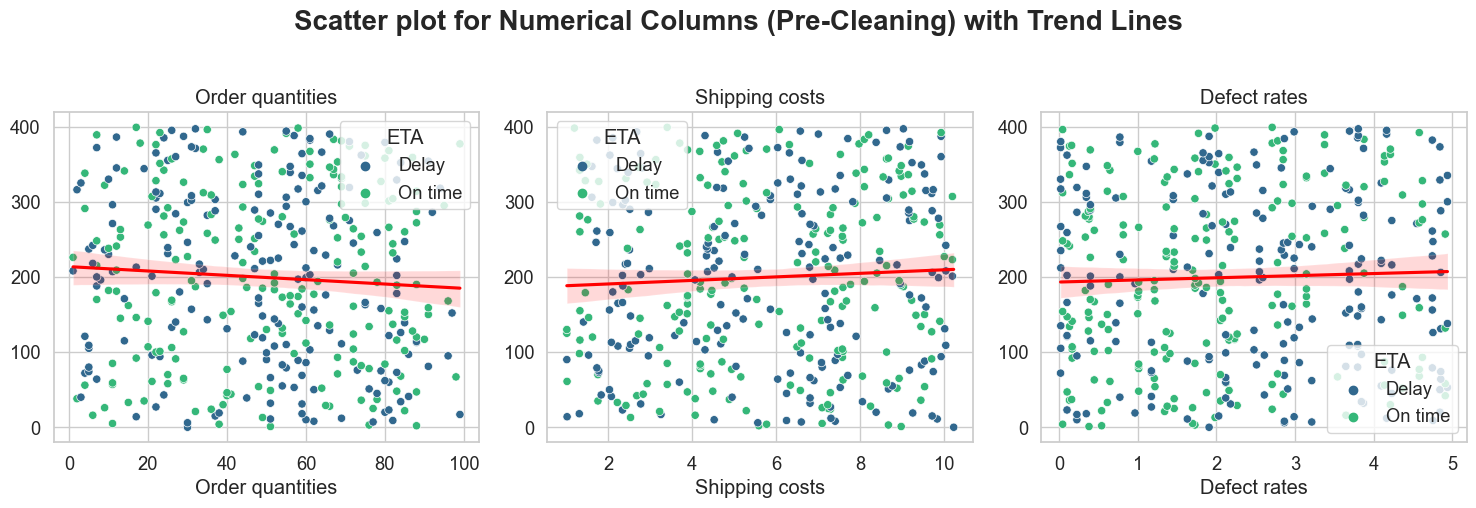

In [11]:
ncols = 3
nrows = max(1, -(-len(numerical_columns) // ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.scatterplot(x=df[col], y=df.index, ax=axes[i], hue=df['ETA'], palette='viridis')
    sns.regplot(x=df[col], y=df.index, ax=axes[i], scatter=False, color='red')
    axes[i].set_title(col)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Scatter plot for Numerical Columns (Pre-Cleaning) with Trend Lines', fontsize=20, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

From the scatterplots and regression plots above. It can be concluded that the data is not homocedastic, non-parametric and having no pattern. Therefore, a non-parametric modelling seems more preferable.

#### *ETA Imbalance Analysis*

ETA
On time    0.5175
Delay      0.4825
Name: proportion, dtype: float64

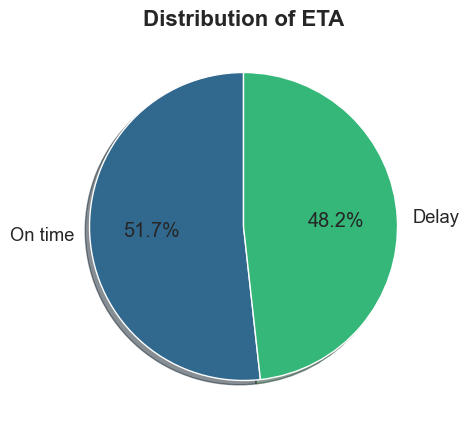

In [12]:
eta_imbalance = df['ETA'].value_counts(normalize=True)

display(eta_imbalance)

colors = sns.color_palette('viridis', len(eta_imbalance))

plt.figure(figsize=(5, 5))
plt.pie(eta_imbalance, labels=eta_imbalance.index, autopct='%1.1f%%', colors=colors, startangle=90, shadow=True)
plt.title('Distribution of ETA', fontsize=16, fontweight='bold')
plt.show()


from the distribution of `ETA`, the overall data is balance even there might be a slight imbalance within  approximately 4%.

<br>

## **Data Splitting**

#### *Define X and Y*

In [13]:
eta_mapping = {'On time':0, 'Delay': 1}

df['ETA'] = df['ETA'].map(eta_mapping)

In [14]:
df['ETA'].value_counts(normalize=True)

ETA
0    0.5175
1    0.4825
Name: proportion, dtype: float64

Please kindly be reminded that the value for `Delay is 1` while the value for `On time is 0`.

#### *Splitting*

In [15]:
x = df.drop('ETA', axis=1)
y = df['ETA']
r_state = 42

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=r_state,
                                                    stratify= y)

<br>

## **Modelling**

#### *Define Model*

In [17]:
logreg = LogisticRegression(random_state=r_state)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=r_state)
gbm = GradientBoostingClassifier(random_state=r_state)
lgbm = lgb.LGBMClassifier(random_state=r_state)
xgb = XGBClassifier(random_state = r_state)
ada = AdaBoostClassifier(random_state=r_state)

models = [logreg, knn, dtree, gbm, lgbm, xgb, ada]

In [18]:
categorical_columns = [col for col in x_train if pd.api.types.is_object_dtype(x_train[col])]
categorical_columns

['Product type', 'Shipping carriers', 'Origin', 'Inspection results', 'Routes']

For start model, we are going to compare each model, therefore all models are included.

#### *Transformer*

In [19]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output= False, drop='first'), categorical_columns)
], remainder= 'passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Product type', 'Shipping carriers', 'Origin',
                                  'Inspection results', 'Routes'])])

Since the data I received have many categorical columns and each categorical value in each columns only has little variations. Therefore, Im using `Onehot` encoder for the encoding with `drop = 'first'` to avoid multicollineariy. While the other numerical using `passthrough` since we will ignore and use the numerical value into considerations

#### *Benchmarking*

In [20]:
benchmark = {'Model Name': [], 'Precision Score': [],'Precision Std dev': [], 'Resample Name': [], 'Tuning': []}

for model in models:

    estimator = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])

    cv_search = cross_validate(estimator=estimator, X = x_train, y = y_train, cv=5, n_jobs = -1, scoring = 'precision')

    display(cv_search)

    benchmark['Model Name'].append(model.__class__.__name__)
    benchmark['Precision Score'].append(cv_search['test_score'].mean())
    benchmark['Precision Std dev'].append(cv_search['test_score'].std())
    benchmark['Resample Name'].append('None')
    benchmark['Tuning'].append('None')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

{'fit_time': array([0.03183293, 0.00968504, 0.00786185, 0.00820971, 0.00800586]),
 'score_time': array([0.00512099, 0.00281715, 0.0027678 , 0.00277305, 0.00261092]),
 'test_score': array([0.65384615, 0.48648649, 0.61538462, 0.53333333, 0.66666667])}

{'fit_time': array([0.00438094, 0.00436497, 0.00717211, 0.00409126, 0.00603294]),
 'score_time': array([0.00364184, 0.00362992, 0.00775099, 0.00883889, 0.00378609]),
 'test_score': array([0.56756757, 0.51724138, 0.48275862, 0.60714286, 0.73076923])}

{'fit_time': array([0.003479  , 0.00955224, 0.00662589, 0.00893903, 0.00460911]),
 'score_time': array([0.00170898, 0.00265694, 0.00248408, 0.00406075, 0.00387692]),
 'test_score': array([0.86206897, 0.75      , 0.78125   , 0.89285714, 0.87096774])}

{'fit_time': array([0.05458999, 0.04941225, 0.06054401, 0.05289197, 0.05636215]),
 'score_time': array([0.0027709 , 0.00328279, 0.0020473 , 0.00225592, 0.00202608]),
 'test_score': array([0.84848485, 0.73529412, 0.78787879, 0.82352941, 0.77777778])}

[LightGBM] [Info] Number of positive: 123, number of negative: 133[LightGBM] [Info] Number of positive: 123, number of negative: 133

[LightGBM] [Info] Number of positive: 123, number of negative: 133[LightGBM] [Info] Number of positive: 124, number of negative: 132
[LightGBM] [Info] Number of positive: 123, number of negative: 133

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

{'fit_time': array([0.55467606, 0.57119274, 0.58826613, 0.56227708, 0.58024597]),
 'score_time': array([0.00742078, 0.00496507, 0.00530005, 0.00674582, 0.00696969]),
 'test_score': array([0.78571429, 0.77419355, 0.82352941, 0.72222222, 0.83333333])}

{'fit_time': array([0.02357101, 0.02928495, 0.02292085, 0.020787  , 0.02092123]),
 'score_time': array([0.003757  , 0.00253987, 0.00459909, 0.00232911, 0.00497794]),
 'test_score': array([0.85185185, 0.80645161, 0.93333333, 0.84848485, 0.93103448])}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

{'fit_time': array([0.04202199, 0.05089498, 0.03451276, 0.0474062 , 0.03912902]),
 'score_time': array([0.00375223, 0.00765181, 0.00361919, 0.003968  , 0.00361013]),
 'test_score': array([0.76666667, 0.66666667, 0.74074074, 0.6875    , 0.6875    ])}

In [21]:
# The mean value of Precision Standard Deviation for a reference

std_total = 0

for std in benchmark['Precision Std dev']:
    std_total += std

std_dev_mean = std_total / len(benchmark['Precision Std dev'])
std_dev_mean

0.05394949401414462

In [22]:
pd.DataFrame(benchmark).sort_values(by='Precision Score', ascending= False)

,Model Name,Precision Score,Precision Std dev,Resample Name,Tuning
5,XGBClassifier,0.874231,0.049955,None,None
2,DecisionTreeClassifier,0.831429,0.055541,None,None
3,GradientBoostingClassifier,0.794593,0.038951,None,None
4,LGBMClassifier,0.787799,0.039597,None,None
6,AdaBoostClassifier,0.709815,0.037540,None,None
0,LogisticRegression,0.591143,0.070026,None,None
1,KNeighborsClassifier,0.581096,0.086036,None,None


              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           1       0.90      0.90      0.90        39

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80



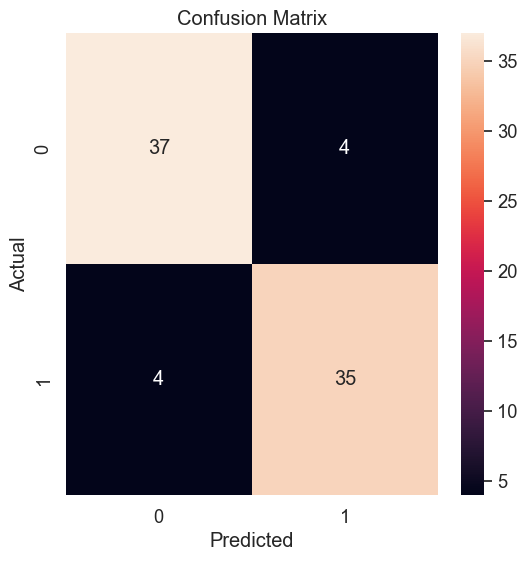

In [23]:
x_train_transformed = pd.DataFrame(data = transformer.fit_transform(x_train), columns= transformer.get_feature_names_out())
x_test_transformed = pd.DataFrame(data = transformer.transform(x_test), columns= transformer.get_feature_names_out())

xgb.fit(x_train_transformed, y_train)
y_pred = xgb.predict(x_test_transformed)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".4g")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.76      0.78        41
           1       0.76      0.82      0.79        39

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



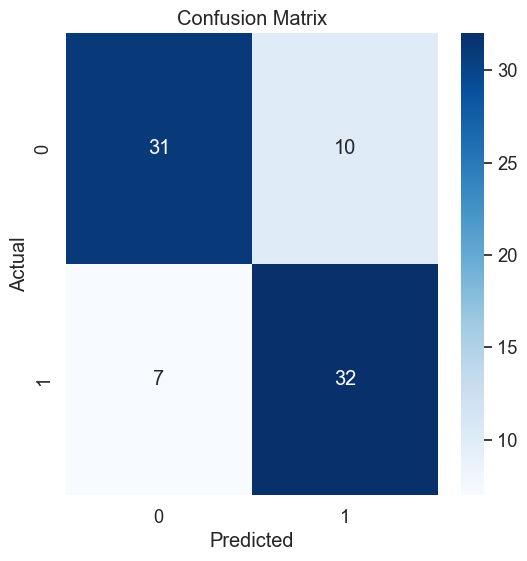

In [24]:
x_train_transformed = pd.DataFrame(data = transformer.fit_transform(x_train), columns= transformer.get_feature_names_out())
x_test_transformed = pd.DataFrame(data = transformer.transform(x_test), columns= transformer.get_feature_names_out())

dtree.fit(x_train_transformed, y_train)
y_pred = dtree.predict(x_test_transformed)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".4g", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

For the result in train set and test set, the model of Extreme Gradient Boost Classifier is the one that explains the most and reaching the precision accuracy by 0.9

Therefore, I'm using XGB for the benchmarking.

<br>

## **Feature Selection**

#### *Recursive feature elimination (RFE)*

In [25]:
model = xgb
features_transformed = x_train_transformed.columns

x_train_transformed = pd.DataFrame(data = transformer.fit_transform(x_train), columns= transformer.get_feature_names_out())
results = {'Number of Features': [], 'Precision Score': [], 'Selected Features': []}

for n_features in range(1, x_train_transformed.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(x_train_transformed, y_train)

    scores = cross_val_score(rfe, x_train_transformed, y_train, cv=5, n_jobs=-1, scoring='precision')

    results['Number of Features'].append(n_features)
    results['Precision Score'].append(np.mean(scores))

    selected_features = np.array(features_transformed)[rfe.support_]
    results['Selected Features'].append(", ".join(selected_features))

In [26]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Precision Score', ascending= False).head(5)
results_df

,Number of Features,Precision Score,Selected Features
6,7,0.958044,"onehot__Product type_haircare, onehot__Origin_..."
5,6,0.957599,"onehot__Product type_haircare, onehot__Origin_..."
7,8,0.939066,"onehot__Product type_haircare, onehot__Shippin..."
11,12,0.889286,"onehot__Product type_haircare, onehot__Shippin..."
14,15,0.874231,"onehot__Product type_haircare, onehot__Product..."


In [27]:
results_df.iloc[0]['Selected Features']

'onehot__Product type_haircare, onehot__Origin_Chennai, onehot__Origin_Delhi, onehot__Origin_Mumbai, onehot__Inspection results_Pass, onehot__Routes_Route C, remainder__Defect rates'

In [28]:
selected_features = [
    'Product type', 
    'Origin', 
    'Inspection results', 
    'Routes', 
    'Defect rates'
]

It is found that from all of the features, the most important features to determine ETA is these 5 features above.

#### *Adjusted Transformer*

In [29]:
adj_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False, drop= 'first'), ['Product type', 'Origin', 'Inspection results', 'Routes']),
    ('pass', 'passthrough', ['Defect rates'])
], remainder= 'drop')

adj_transformer

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Product type', 'Origin',
                                  'Inspection results', 'Routes']),
                                ('pass', 'passthrough', ['Defect rates'])])

In [30]:
pd.DataFrame(adj_transformer.fit_transform(x_train), columns= adj_transformer.get_feature_names_out()).sample(5)

,onehot__Product type_haircare,onehot__Product type_skincare,onehot__Origin_Chennai,onehot__Origin_Delhi,onehot__Origin_Kolkata,onehot__Origin_Mumbai,onehot__Inspection results_Pass,onehot__Inspection results_Pending,onehot__Routes_Route B,onehot__Routes_Route C,pass__Defect rates
202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.018608
223,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.580593
230,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.018608
281,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.219382
192,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.874001


#### *RFE Test*

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        39

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



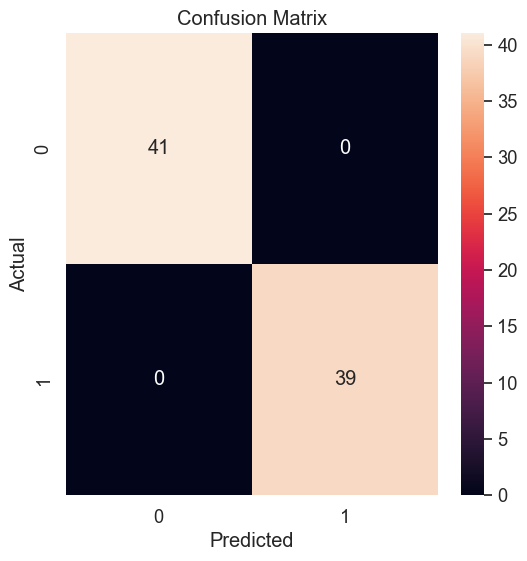

In [31]:
estimator = Pipeline([
    ('transformer', adj_transformer),
    ('model', xgb)
])

estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".4g")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the RFE test it can be seen that features seletion using RFE and XGB will increase the recall accuracy from `0.90` to `1`. Means that the model can predict with 100% accuracy.

<br>

## **Hyperparameter Tuning**

#### *Define Parameter for XGB*

In [32]:
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'model__max_depth': [3, 5, 7, 9, 11, 13, 15],
    'model__min_child_weight': [1, 3, 5, 7, 9],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'model__reg_lambda': [0, 0.01, 0.1, 1, 10, 100],
    'model__scale_pos_weight': [1, 3, 5, 7, 9],
    'model__random_state': [42]
}

#### *Tuning Test*

In [33]:
estimator = Pipeline([
    ('transformer', adj_transformer),
    ('model', xgb)
])

random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=100,
    scoring='precision',
    cv=7,
    verbose=1,
    random_state=r_state,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best Precision: ", random_search.best_score_)
best_model = random_search.best_estimator_
display(best_model)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_

Best parameters found:  {'model__subsample': 0.7, 'model__scale_pos_weight': 1, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.1, 'model__random_state': 42, 'model__n_estimators': 100, 'model__min_child_weight': 1, 'model__max_depth': 11, 'model__learning_rate': 0.2, 'model__gamma': 0.3, 'model__colsample_bytree': 0.7}
Best Precision:  0.9627003845016268


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Product type', 'Origin',
                                                   'Inspection results',
                                                   'Routes']),
                                                 ('pass', 'passthrough',
                                                  ['Defect rates'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.97      0.97      0.97        39

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



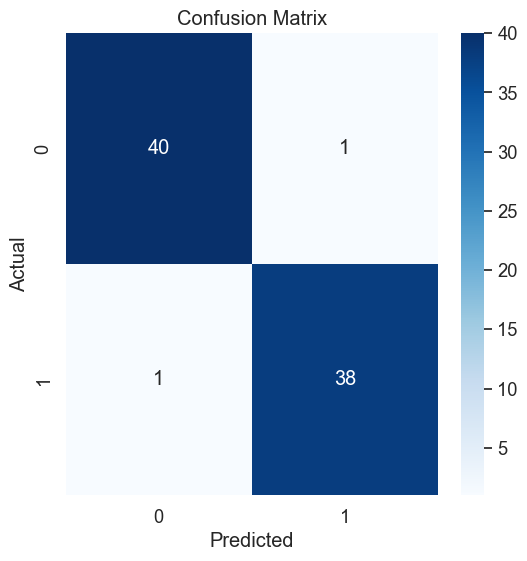

In [34]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".4g", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix and classification report above it implies that the model with a tuning for XGB will lower the precision prediction rate. Therefore, we are going to use the model without the tuning but using selected features.

<br>

## **Explainable AI**

#### *SHapley Additive exPlanations (SHAP)*

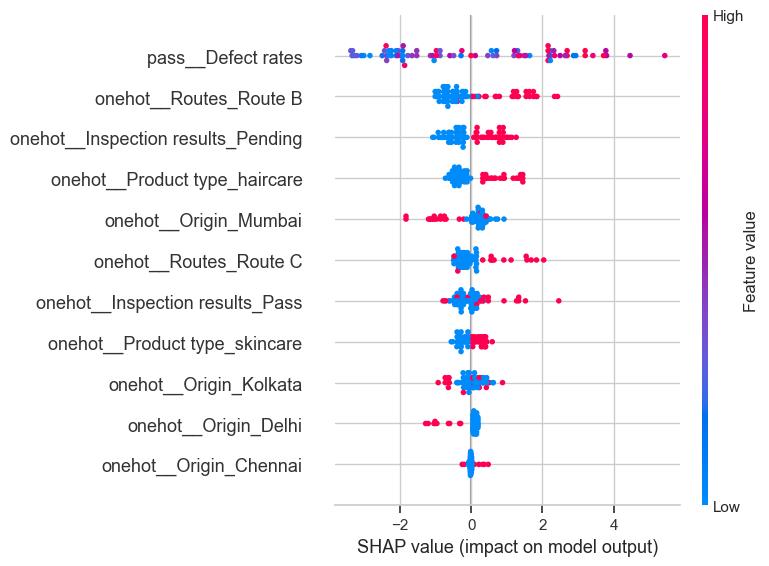

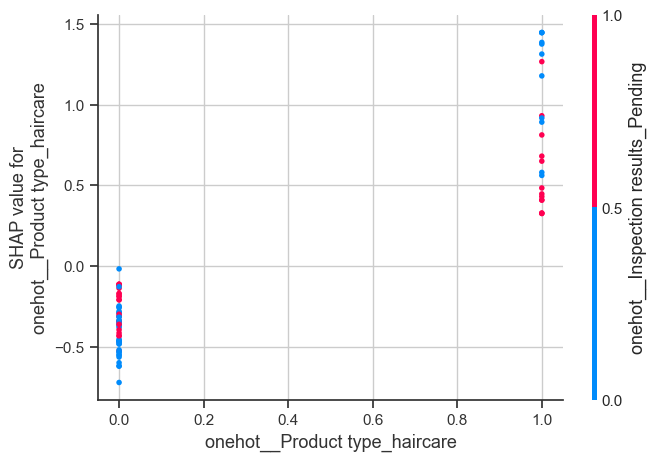

In [35]:
x_test_transformed = estimator.named_steps['transformer'].transform(x_test)
feature_names = estimator.named_steps['transformer'].get_feature_names_out()

# Create a SHAP explainer
explainer = shap.Explainer(estimator.named_steps['model'], x_test_transformed)

# Calculate SHAP values
shap_values = explainer(x_test_transformed)

# Visualize SHAP values for a single prediction
shap.initjs()
shap.force_plot(shap_values[0], feature_names=feature_names)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, x_test_transformed, feature_names=feature_names)

# Visualize SHAP dependence plot
shap.dependence_plot(0, shap_values.values, x_test_transformed, feature_names=feature_names)

From the shap above it can be concluded that the most important factor to determine delay or on time in ETA is by defect rates, followed route and inspection result. The higher the defect rates, also increase the chances of the delay.

#### *Regression Plot*

<Axes: xlabel='Defect rates', ylabel='ETA'>

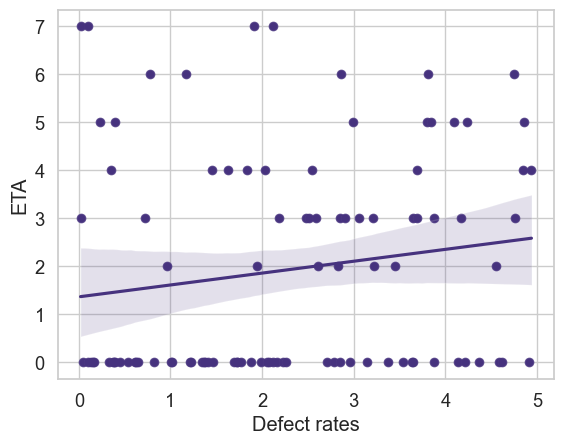

In [36]:
defect_eta = pd.DataFrame(df.groupby('Defect rates')['ETA'].sum()).reset_index()
defect_eta

sns.scatterplot(data=defect_eta, y = 'ETA', x='Defect rates')
sns.regplot(data=defect_eta, y = 'ETA', x='Defect rates')

From this regression plot, it found that the shipping with higher defect rates is actually tend to have a higher ETA or delay rates. To understand the relationship defect rates and ETA, a field study needs to be analyze.

#### *Bar Plot*

<Axes: xlabel='Routes', ylabel='ETA'>

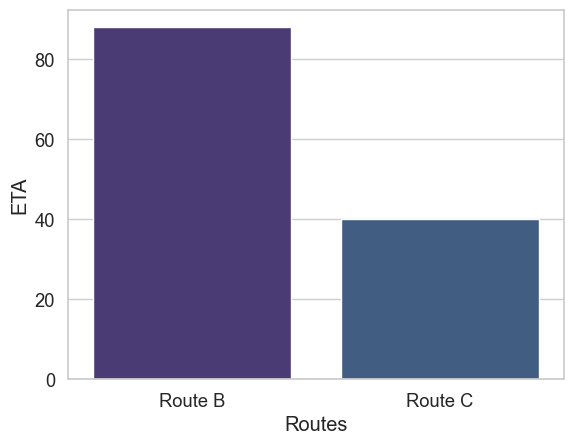

In [37]:
routes_eta = pd.DataFrame(df.groupby('Routes')['ETA'].sum()).reset_index().tail(2)
sns.barplot(data=routes_eta, x = 'Routes', y='ETA')

From this bar chart it found that Route B has a higher and significance impact to the delay of the shipping. Therefore, field study also needed for the route prediction.

<br>

## **Conclusion & Recommendation**

`Without Machine Learning`

Previously if the port authority is not using any Machine Learning, then port authority might not know which ship will arrive on time or delay. This could lead to major traffic disaster or unnecessary operation cost.

Assume if the cost of handling ship is Rp 10.000.000 for each ship and all ships assumed to arrive on time, then the handling fee that port authority will spend without machine learning is Rp 800.000.000

`With Machine Learning`

After the port authority using Machine Learning, then port authority might not know which ship will arrive on time or delay. This could lead to better management in traffic disaster or operation cost.

Assume if the cost of handling ship is Rp 10.000.000 for each ship and port authority knows that 41 ships will arrive on time, then the handling fee that port authority will spend with machine learning is Rp 410.000.000

This will saves port authority `Rp 390.000.000 or 49%` of the operational cost